In [18]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [19]:
paradas = gpd.read_file('paradasBuses.geojson')
servicios_salud = gpd.read_file('serviciosSalud.geojson')
comunas_urbanas  = gpd.read_file('r13.geojson')

In [20]:
comuna_codes = {
    '13101': 'Santiago', '13102': 'Cerrillos', '13103': 'Cerro Navia', '13104': 'Conchali',
    '13105': 'El Bosque', '13106': 'Estacion Central', '13107': 'Huechuraba', 
    '13108': 'Independencia', '13109': 'La Cisterna', '13110': 'La Florida',
    '13111': 'La Granja', '13112': 'La Pintana', '13113': 'La Reina', 
    '13114': 'Las Condes', '13115': 'Lo Barnechea', '13116': 'Lo Espejo',
    '13117': 'Lo Prado', '13118': 'Macul', '13119': 'Maipu', '13120': 'Nunoa',
    '13121': 'Pedro Aguirre Cerda', '13122': 'Penalolen', '13123': 'Providencia',
    '13124': 'Pudahuel', '13125': 'Quilicura', '13126': 'Quinta Normal',
    '13127': 'Recoleta', '13128': 'Renca', '13129': 'San Joaquin', 
    '13130': 'San Miguel', '13131': 'San Ramon', '13132': 'Vitacura',
    '13201': 'Puente Alto'
}

In [21]:
comunas_urbanas = comunas_urbanas[comunas_urbanas['codigo_comuna'].astype(str).isin(comuna_codes.keys())]

comunas_urbanas['nombre_comuna'] = comunas_urbanas['codigo_comuna'].map(comuna_codes)

In [22]:
comunas_urbanas = comunas_urbanas.dissolve(by='codigo_comuna', as_index=False)

In [ ]:
crs = comunas_urbanas.crs

paradas = paradas.to_crs(crs)
servicios_salud = servicios_salud.to_crs(crs)

In [ ]:
paradas_comunas = gpd.sjoin(paradas, comunas_urbanas[['codigo_comuna', 'nombre_comuna', 'geometry']], how='left', op='within')

servicios_comunas = gpd.sjoin(servicios_salud, comunas_urbanas[['codigo_comuna', 'nombre_comuna', 'geometry']], how='left', op='within')

In [ ]:
comunas_urbanas['area_km2'] = comunas_urbanas['geometry'].area / 1e6  

paradas_por_comuna = paradas_comunas.groupby('codigo_comuna').size().reset_index(name='num_paradas')

servicios_por_comuna = servicios_comunas.groupby('codigo_comuna').size().reset_index(name='num_servicios')

comunas_densidad = comunas_urbanas[['codigo_comuna', 'nombre_comuna', 'area_km2']].merge(
    paradas_por_comuna, on='codigo_comuna', how='left').merge(
    servicios_por_comuna, on='codigo_comuna', how='left')

comunas_densidad['num_paradas'] = comunas_densidad['num_paradas'].fillna(0)
comunas_densidad['num_servicios'] = comunas_densidad['num_servicios'].fillna(0)

comunas_densidad['densidad_paradas'] = comunas_densidad['num_paradas'] / comunas_densidad['area_km2']
comunas_densidad['densidad_servicios'] = comunas_densidad['num_servicios'] / comunas_densidad['area_km2']

In [ ]:
correlacion = comunas_densidad[['densidad_paradas', 'densidad_servicios']].corr(method='pearson')

print("Matriz de correlación:")
print(correlacion)

Matriz de correlación:
                    densidad_paradas  densidad_servicios
densidad_paradas            1.000000            0.296532
densidad_servicios          0.296532            1.000000


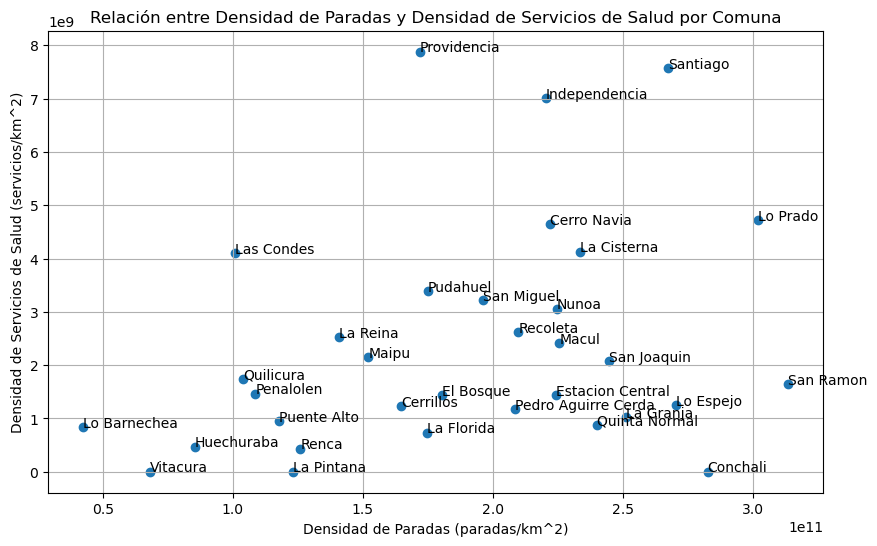

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(comunas_densidad['densidad_paradas'], comunas_densidad['densidad_servicios'])

for i, txt in enumerate(comunas_densidad['nombre_comuna']):
    plt.annotate(txt, (comunas_densidad['densidad_paradas'][i], comunas_densidad['densidad_servicios'][i]))

plt.xlabel('Densidad de Paradas (paradas/km^2)')
plt.ylabel('Densidad de Servicios de Salud (servicios/km^2)')
plt.title('Relación entre Densidad de Paradas y Densidad de Servicios de Salud por Comuna')
plt.grid(True)
plt.show()